#**Implementation**

[nltk_data] Downloading package wordnet to /root/nltk_data...


Training DataFrame Shape: (2258, 10)
             Datetime                  Merchant Name  Sub Category  \
0 2024-10-07 17:00:00  Warung Sate Madura - Ciwareng           NaN   
1 2022-10-24 10:15:00                     nurugel.id           NaN   
2 2024-04-16 01:14:21                      ShopeePay           NaN   
3 2024-04-30 00:00:00                           Grab           NaN   
4 2023-05-31 00:00:00                           Grab           NaN   

         Category  Amount Currency Transaction Type Payment Method  \
0            FOOD   44000      IDR          EXPENSE           Cash   
1   ENTERTAINMENT  651300      IDR          EXPENSE          GoPay   
2           OTHER   21000      IDR          EXPENSE          BRImo   
3  TRANSPORTATION   32000      IDR          EXPENSE       OVO Cash   
4  TRANSPORTATION   45000      IDR          EXPENSE       OVO Cash   

                Transaction ID            Notes  
0               A-7W6DA9CWWIKG   GrabFood Order  
1  INV/20221024/MPL/2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2966 - loss: 2.3511 - val_accuracy: 0.8274 - val_loss: 1.2267
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7715 - loss: 1.1097 - val_accuracy: 0.8872 - val_loss: 0.6906
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8501 - loss: 0.7648 - val_accuracy: 0.9071 - val_loss: 0.5411
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9048 - loss: 0.5497 - val_accuracy: 0.9115 - val_loss: 0.4569
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9047 - loss: 0.4802 - val_accuracy: 0.9204 - val_loss: 0.4049
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9221 - loss: 0.4145 - val_accuracy: 0.9204 - val_loss: 0.3895
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9193 - loss: 0.3654 - val_accuracy: 0.9204 - val_loss: 0.3707
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9267 - loss: 0.3206 - val_accuracy: 0.9204 - val_loss: 0.

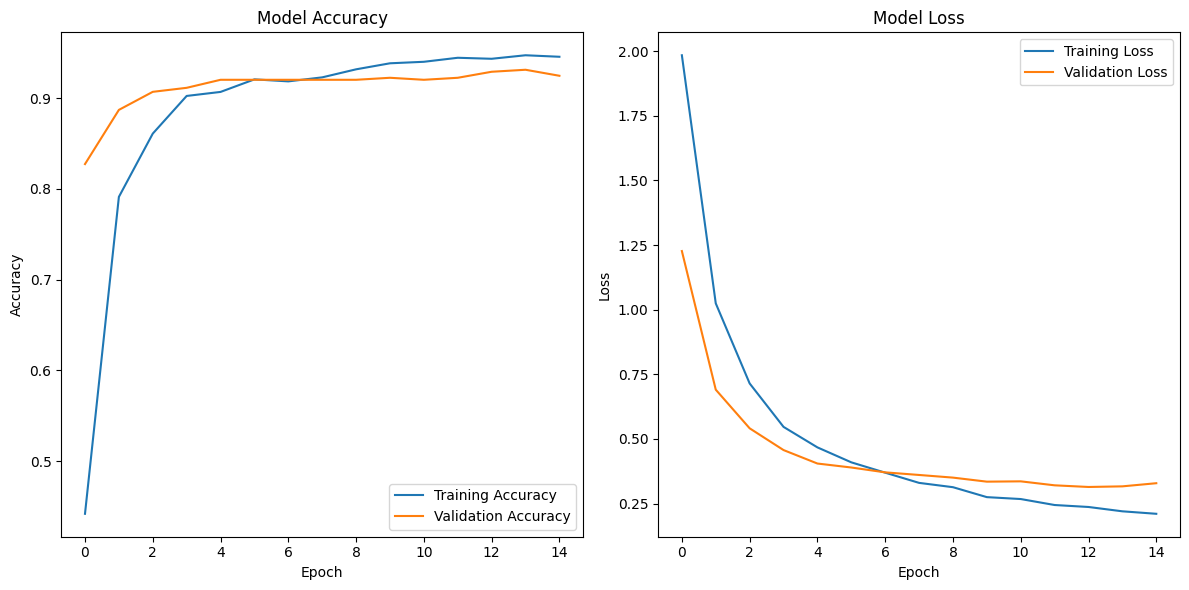

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import nltk
from nltk.corpus import wordnet
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout, CategoryEncoding, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from datetime import datetime
from decimal import Decimal
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import StringLookup
#from ..Email_Data_Extraction.extractors.base_extractor import TransactionData

# Ensure nltk WordNet is downloaded
nltk.download('wordnet')

# Save and load pickled objects
def save_pickle(obj, filename):
    """ Save the object to a pickle file. """
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(filename):
    """ Load the object from a pickle file. """
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Function for synonym replacement in the "Notes" column
def augment_text_with_synonyms(text, num_replacements=2):
    words = text.split()
    for _ in range(num_replacements):
        word_idx = random.randint(0, len(words) - 1)
        synonyms = wordnet.synsets(words[word_idx])
        if synonyms:
            if synonyms[0]:
                synonym = synonyms[0].lemmas()[0].name()
                if synonym != words[word_idx]:
                    words[word_idx] = synonym
    return ' '.join(words)

# Process datetime-related features
def process_datetime_features(df):
    """ Process datetime-related features like Year, Month, DayOfWeek, etc. """
    df['Datetime'] = pd.to_datetime(df['Datetime'])  # Handle invalid dates gracefully
    df['Year'] = df['Datetime'].dt.year.astype(np.int32)
    df['Month'] = df['Datetime'].dt.month.astype(np.int32)
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek.astype(np.int32)
    df['DayOfMonth'] = df['Datetime'].dt.day.astype(np.int32)
    df['WeekOfYear'] = df['Datetime'].dt.isocalendar().week.astype(np.int32)
    df['IsWeekend'] = df['Datetime'].dt.dayofweek.isin([5, 6]).astype(np.int32)
    return df

# Preprocess the training and test datasets
def preprocess_transaction_data(train_df, test_df):
    """Preprocess the training and testing data, applying text augmentation, TF-IDF, category encoding, and scaling."""

    # Process datetime features
    train_df = process_datetime_features(train_df)
    test_df = process_datetime_features(test_df)
    print("Datetime Features Processed.")

    # Ensure all values in "Notes" and "Merchant Name" columns are strings
    train_df['Notes'] = train_df['Notes'].astype(str)
    train_df['Merchant Name'] = train_df['Merchant Name'].astype(str)
    test_df['Notes'] = test_df['Notes'].astype(str)
    test_df['Merchant Name'] = test_df['Merchant Name'].astype(str)

    # Apply text augmentation on "Notes" and "Merchant Name" columns
    train_df['Notes'] = train_df['Notes'].apply(lambda x: augment_text_with_synonyms(x, num_replacements=2))
    train_df['Merchant Name'] = train_df['Merchant Name'].apply(lambda x: augment_text_with_synonyms(x, num_replacements=1))

    # TF-IDF for 'Notes' and 'Merchant Name'
    tfidf_vectorizer_notes = TextVectorization(max_tokens=150, output_mode='tf-idf')
    tfidf_vectorizer_notes.adapt(tf.constant(train_df['Notes'].values, dtype=tf.string))
    tfidf_train_notes = tfidf_vectorizer_notes(tf.constant(train_df['Notes'].values, dtype=tf.string)).numpy().astype(np.float32)
    tfidf_test_notes = tfidf_vectorizer_notes(tf.constant(test_df['Notes'].values, dtype=tf.string)).numpy().astype(np.float32)

    tfidf_vectorizer_merchant = TextVectorization(max_tokens=150, output_mode='tf-idf')
    tfidf_vectorizer_merchant.adapt(tf.constant(train_df['Merchant Name'].values, dtype=tf.string))
    tfidf_train_merchant = tfidf_vectorizer_merchant(tf.constant(train_df['Merchant Name'].values, dtype=tf.string)).numpy().astype(np.float32)
    tfidf_test_merchant = tfidf_vectorizer_merchant(tf.constant(test_df['Merchant Name'].values, dtype=tf.string)).numpy().astype(np.float32)

    save_pickle(tfidf_vectorizer_notes, 'trained/notes_vectorizer.pkl')
    save_pickle(tfidf_vectorizer_merchant, 'trained/merchant_vectorizer.pkl')

    # Ensure all categorical columns are strings
    train_df['Payment Method'] = train_df['Payment Method'].astype(str)
    train_df['Transaction Type'] = train_df['Transaction Type'].astype(str)
    test_df['Payment Method'] = test_df['Payment Method'].astype(str)
    test_df['Transaction Type'] = test_df['Transaction Type'].astype(str)

    # String Lookup for categorical columns
    lookup_payment_method = tf.keras.layers.StringLookup()
    lookup_transaction_type = tf.keras.layers.StringLookup()

    # Adapt lookup layers
    lookup_payment_method.adapt(tf.constant(train_df['Payment Method'], dtype=tf.string))
    lookup_transaction_type.adapt(tf.constant(train_df['Transaction Type'], dtype=tf.string))

    # Apply lookup transformation
    train_payment_method = lookup_payment_method(tf.constant(train_df['Payment Method'], dtype=tf.string)).numpy()
    train_transaction_type = lookup_transaction_type(tf.constant(train_df['Transaction Type'], dtype=tf.string)).numpy()
    test_payment_method = lookup_payment_method(tf.constant(test_df['Payment Method'], dtype=tf.string)).numpy()
    test_transaction_type = lookup_transaction_type(tf.constant(test_df['Transaction Type'], dtype=tf.string)).numpy()

    train_payment_method_onehot = tf.one_hot(train_payment_method, depth=lookup_payment_method.vocabulary_size()).numpy().astype(np.float32)
    train_transaction_type_onehot = tf.one_hot(train_transaction_type, depth=lookup_transaction_type.vocabulary_size()).numpy().astype(np.float32)
    test_payment_method_onehot = tf.one_hot(test_payment_method, depth=lookup_payment_method.vocabulary_size()).numpy().astype(np.float32)
    test_transaction_type_onehot = tf.one_hot(test_transaction_type, depth=lookup_transaction_type.vocabulary_size()).numpy().astype(np.float32)

    categorical_train = np.hstack((train_payment_method_onehot, train_transaction_type_onehot))
    categorical_test = np.hstack((test_payment_method_onehot, test_transaction_type_onehot))

    save_pickle(lookup_payment_method, 'trained/lookup_payment_method.pkl')
    save_pickle(lookup_transaction_type, 'trained/lookup_transaction_type.pkl')

    # Scaling numerical features
    scaler = StandardScaler()
    numerical_features = ['Amount', 'Year', 'Month', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'IsWeekend']
    numerical_train = train_df[numerical_features].astype(np.float32)
    numerical_test = test_df[numerical_features].astype(np.float32)

    numerical_train_scaled = scaler.fit_transform(numerical_train)
    numerical_test_scaled = scaler.transform(numerical_test)

    save_pickle(scaler, 'trained/scaler.pkl')

    # Combine all features
    X_train_combined = np.hstack((numerical_train_scaled, categorical_train, tfidf_train_notes, tfidf_train_merchant))
    X_test_combined = np.hstack((numerical_test_scaled, categorical_test, tfidf_test_notes, tfidf_test_merchant))

    return X_train_combined, X_test_combined, scaler, tfidf_vectorizer_notes, tfidf_vectorizer_merchant, lookup_payment_method, lookup_transaction_type

# Create a complex model for the task
def create_model(input_dim, output_dim, category_encoding_layer, tfidf_vectorizer_notes, tfidf_vectorizer_merchant):
    model = Sequential([
        Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=1e-8, l2=1e-7)),
        BatchNormalization(momentum=0.9),
        LeakyReLU(alpha=0.1),
        Dropout(0.1),
        Dense(512, kernel_regularizer=regularizers.l1_l2(l1=1e-8, l2=1e-7)),
        BatchNormalization(momentum=0.9),
        LeakyReLU(alpha=0.1),
        Dropout(0.1),
        Dense(256, kernel_regularizer=regularizers.l1_l2(l1=1e-8, l2=1e-7)),
        BatchNormalization(momentum=0.9),
        LeakyReLU(alpha=0.1),
        Dropout(0.1),
        Dense(128, kernel_regularizer=regularizers.l1_l2(l1=1e-8, l2=1e-7)),
        BatchNormalization(momentum=0.9),
        LeakyReLU(alpha=0.1),
        Dropout(0.1),
        Dense(output_dim, activation='softmax')
    ])
    return model

# Training and evaluation function
def train_and_evaluate(training_data_path, testing_data_path):
    """Trains and evaluates the model using the provided training data from .xlsx."""

    # Load the training dataset from .xlsx file
    train_df = pd.read_excel(training_data_path)
    print("Training DataFrame Shape:", train_df.shape)
    print(train_df.head())

    # Load the test dataset from .xlsx file
    test_df = pd.read_excel(testing_data_path)
    print("Test DataFrame Shape (Before Setting 'Category' to NaN):", test_df.shape)

    # Ensure 'Category' column exists in the test data, set to NaN
    if 'Category' not in test_df.columns:
        test_df['Category'] = np.nan
    else:
        test_df['Category'] = np.nan  # Overwrite existing Category values with NaN
    print("Test DataFrame Shape (After Setting 'Category' to NaN):", test_df.shape)

    # Preprocess the data
    X_train, X_test, scaler, tfidf_vectorizer_notes, tfidf_vectorizer_merchant, lookup_payment_method, lookup_transaction_type = preprocess_transaction_data(train_df, test_df)
    print("X_train Shape:", X_train.shape)
    print("X_test Shape:", X_test.shape)

    # Encode the target labels for training data
    le_category = LabelEncoder()
    y_train = le_category.fit_transform(train_df['Category'])
    print("y_train Shape:", y_train.shape)

    # If `Category` in the test data is NaN, y_test will be empty
    y_test = le_category.transform(test_df['Category'].dropna()) if not test_df['Category'].isna().all() else np.array([])
    print("y_test Shape:", y_test.shape)

    save_pickle(le_category, 'trained/label_encoder.pkl')

    # One-hot encode the training labels
    y_train_onehot = tf.keras.utils.to_categorical(y_train)
    print("y_train_onehot Shape:", y_train_onehot.shape)

    # One-hot encode the test labels if they exist
    y_test_onehot = tf.keras.utils.to_categorical(y_test) if y_test.size > 0 else None
    if y_test_onehot is not None:
        print("y_test_onehot Shape:", y_test_onehot.shape)

    # Create the model
    model = create_model(X_train.shape[1], y_train_onehot.shape[1], lookup_payment_method, tfidf_vectorizer_notes, tfidf_vectorizer_merchant)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train_onehot, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

    # Evaluate the model on the test set if labels are available
    if y_test.size > 0 and X_test.size > 0:
        print("Evaluating on test data...")
        test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
    else:
        print("Skipping test evaluation: Test data lacks valid 'Category' labels.")

    # Predict the categories for the test data
    if X_test.size > 0:
        print("Making predictions for the test data...")
        y_test_pred = model.predict(X_test)
        y_test_pred_labels = np.argmax(y_test_pred, axis=1)
        category_labels = le_category.classes_
        y_test_pred_categories = category_labels[y_test_pred_labels]
    else:
        print("Skipping prediction: Test data is empty.")

    # Plot the training and validation accuracy
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Example paths (replace with actual file paths)
training_data_path = 'Training_Datasets.xlsx'
testing_data_path = 'Testing_Datasets.xlsx'

# Train and evaluate the model
model = train_and_evaluate(training_data_path, testing_data_path)

#**Save to .keras**

In [2]:
# Save the model in .keras format
model.save("trained/category_prediction_model.keras")
print("Model saved as category_prediction_model.keras")

Model saved as category_prediction_model.keras
